In [69]:
import pandas as pd
import networkx as nx
import re


In [70]:
transcript_map = pd.read_csv('testing.csv')
print(transcript_map)

   pos     type  prob  drop_prob
0   -1     5cap   1.0       0.00
1    3     init   0.5       0.01
2    6  shift-1   0.5       0.00
3    9     stop   0.0       1.00
4   10      end   0.0       1.00


In [71]:
import pandas as pd


def map2nodes(transcript_map):
    """
    Convert a transcript event map into a node map with
    start/end frames and transition states.
    """
    event_map = transcript_map.copy()

    # ---------- HELPERS ----------

    def frame_from_pos(pos):
        return (pos - 1) % 3 + 1

    # ---------- NODE HANDLERS ----------

    def handle_init(df):
        df['start_frame'] = 0
        df['end_frame'] = frame_from_pos(df['pos'])
        df['end'] = df['pos']
        return df

    def handle_stop(df):
        df['start_frame'] = frame_from_pos(df['pos'])
        df['end_frame'] = 0
        df['end'] = df['pos']
        return df

    def handle_shift(df):
        df['shift'] = (
            df['type']
            .str.extract(r'shift([+-]?\d+)')
            .astype(int)
        )
        df['start_frame'] = frame_from_pos(df['pos'])
        df['end'] = df['pos'] + df['shift']
        df['end_frame'] = frame_from_pos(df['end'])
        return df

    def handle_ires(df):
        df['start_frame'] = -1
        df['end_frame'] = frame_from_pos(df['pos'])
        df['end'] = df['pos']
        return df

    def handle_5cap(df):
        df['start_frame'] = -1
        df['end_frame'] = 0
        df['end'] = 1
        return df

    # ---------- HANDLER REGISTRY ----------

    HANDLERS = {
        'init': handle_init,
        'stop': handle_stop,
        'ires': handle_ires,
        '5cap': handle_5cap,
    }

    # ---------- APPLY HANDLERS ----------

    for node_type, handler in HANDLERS.items():
        mask = event_map['type'] == node_type
        if mask.any():
            event_map.loc[mask, ['start_frame', 'end_frame', 'end']] = (
                handler(event_map.loc[mask].copy())
                [['start_frame', 'end_frame', 'end']]
                .values
            )

    # Shift nodes handled separately due to regex-based type
    shift_mask = event_map['type'].str.contains('shift', na=False)
    if shift_mask.any():
        event_map.loc[shift_mask, ['start_frame', 'end_frame', 'end']] = (
            handle_shift(event_map.loc[shift_mask].copy())
            [['start_frame', 'end_frame', 'end']]
            .values
        )

    # ---------- HANDLE END NODE ----------

    end_rows = event_map[event_map['type'] == 'end']
    end_pos = int(end_rows['pos'].iloc[0])
    event_map = event_map.drop(index=end_rows.index)

    max_idx = event_map.index.max()

    terminal_nodes = pd.DataFrame(
        [
            [end_pos, 'end-scan0', 0, 1, 0, -1, end_pos],
            [end_pos, 'end-tran1', 0, 1, 1, -1, end_pos],
            [end_pos, 'end-tran2', 0, 1, 2, -1, end_pos],
            [end_pos, 'end-tran3', 0, 1, 3, -1, end_pos],
        ],
        columns=event_map.columns,
        index=range(max_idx + 1, max_idx + 5),
    )

    event_map = pd.concat([event_map, terminal_nodes])

    # ---------- FINAL CLEANUP ----------

    event_map[['pos', 'end', 'start_frame', 'end_frame']] = (
        event_map[['pos', 'end', 'start_frame', 'end_frame']].astype(int)
    )

    # Probability bookkeeping
    event_map['cont_prob'] = 1 - (event_map['prob'] + event_map['drop_prob'])

    event_map = (
        event_map
        .sort_values('pos')
        .reset_index(drop=True)
        [['pos', 'end', 'type', 'start_frame', 'end_frame',
          'prob', 'drop_prob', 'cont_prob']]
    )

    return event_map

nodemap = map2nodes(transcript_map=transcript_map)
print(nodemap)

   pos  end       type  start_frame  end_frame  prob  drop_prob  cont_prob
0   -1    1       5cap           -1          0   1.0       0.00       0.00
1    3    3       init            0          3   0.5       0.01       0.49
2    6    5    shift-1            3          2   0.5       0.00       0.50
3    9    9       stop            3          0   0.0       1.00       0.00
4   10   10  end-scan0            0         -1   0.0       1.00       0.00
5   10   10  end-tran1            1         -1   0.0       1.00       0.00
6   10   10  end-tran2            2         -1   0.0       1.00       0.00
7   10   10  end-tran3            3         -1   0.0       1.00       0.00


In [72]:
import pandas as pd


def build_eventon_map(nodemap: pd.DataFrame) -> pd.DataFrame:
    """
    Split init / stop / shift nodes into begin and finish event-nodes
    and normalize event metadata in a single pass.
    """

    nodemap = nodemap.copy()

    # ---------- SELECT SPLITTABLE NODES ----------
    split_mask = (
        nodemap['type'].isin(['init', 'stop', '5cap', 'ires']) |
        nodemap['type'].str.contains('shift', na=False)
    )

    split_nodes = nodemap[split_mask].copy()
    keep_nodes = nodemap[~split_mask].copy()

    # ---------- BEGIN EVENTS ----------
    begin = split_nodes.assign(
        pos=split_nodes['pos'],
        start_frame=split_nodes['start_frame'],
        end_frame=split_nodes['end_frame'],
        phase='begin',
        prob=split_nodes['prob'],
        drop_prob=split_nodes['drop_prob'],
        cont_prob=split_nodes['cont_prob'],
    )

    # ---------- FINISH EVENTS ----------
    finish = split_nodes.assign(
        pos=split_nodes['end'],
        start_frame=split_nodes['end_frame'],
        end_frame=split_nodes['end_frame'],
        phase='finish',
        prob=split_nodes['prob'].where(split_nodes['prob'] == 0, 1),
        drop_prob=0,
        cont_prob=1,
    ).dropna(subset=['pos'])

    # ---------- EVENT CLASS ----------
    for df in (begin, finish, keep_nodes):
        df['event_class'] = df['type']
        df['event_class'] = df['event_class'].str.replace(
            r'/(begin|finish)$', '', regex=True
        )
        df['event_class'] = df['event_class'].str.replace(
            r'shift[+-]?\d+', 'shift', regex=True
        )
        df.loc[df['event_class'].str.startswith('end-', na=False),
               'event_class'] = 'end'

    # ---------- SHIFT AMOUNT ----------
    for df in (begin, finish):
        df['shift_amount'] = (
            df['type']
            .str.extract(r'shift([+-]?\d+)')[0]
            .astype(float)
            .fillna(0)
            .astype(int)
        )

    keep_nodes['shift_amount'] = 0
    keep_nodes['phase'] = None

    # ---------- COMBINE ----------
    out = pd.concat(
        [
            keep_nodes.drop(columns=['end'], errors='ignore'),
            begin.drop(columns=['end'], errors='ignore'),
            finish.drop(columns=['end'], errors='ignore'),
        ],
        ignore_index=True,
    )

    # ---------- NODE IDENTIFIER ----------
    print(out)
    out.loc[(out['event_class'] == 'ires') &
            (out['phase'] == 'begin'), 'pos'] = -1
    out['node'] = list(zip(out['pos'], out['start_frame']))

    return out


eventon_map = build_eventon_map(nodemap)
print(eventon_map)

    pos       type  start_frame  end_frame  prob  drop_prob  cont_prob  \
0    10  end-scan0            0         -1   0.0       1.00       0.00   
1    10  end-tran1            1         -1   0.0       1.00       0.00   
2    10  end-tran2            2         -1   0.0       1.00       0.00   
3    10  end-tran3            3         -1   0.0       1.00       0.00   
4    -1       5cap           -1          0   1.0       0.00       0.00   
5     3       init            0          3   0.5       0.01       0.49   
6     6    shift-1            3          2   0.5       0.00       0.50   
7     9       stop            3          0   0.0       1.00       0.00   
8     1       5cap            0          0   1.0       0.00       1.00   
9     3       init            3          3   1.0       0.00       1.00   
10    5    shift-1            2          2   1.0       0.00       1.00   
11    9       stop            0          0   0.0       0.00       1.00   

   event_class  shift_amount   phase 

In [73]:
def advance_position(pos, event_class, phase, shift_amount, cont):
    """
    Apply position change caused by shift events.
    """
    if event_class == 'shift' and phase == 'begin' and not cont:
        return pos + shift_amount
    return pos


In [74]:
def find_next_node(node_map, pos, frame, node):
    """
    Find the next node matching position and frame.
    """
    candidates = node_map[
        (node_map['pos'] >= pos) &
        (node_map['start_frame'] == frame) &
        (node_map['node'] != node) 
        ]

    if candidates.empty:
        return (None,None)

    return candidates.loc[candidates['pos'].idxmin(), 'node']


In [75]:
# cont == True / False → (event_class, phase) → state
STATE_TRANSITIONS = {
    True: {
        ('init',  'begin'):  lambda f: 'scan',
        ('init',  'finish'): lambda f: f'tran{f}',

        ('shift', 'begin'):  lambda f: f'tran{f}',
        ('shift', 'finish'): lambda f: f'tran{f}',

        ('stop',  'begin'):  lambda f: f'tran{f}',
        ('stop',  'finish'): lambda f: 'scan',

        ('ires',  'begin'):  lambda f: f'rcyc{f}',
        ('ires',  'finish'): lambda f: f'tran{f}',

        ('5cap',  'begin'):  lambda f: f'rcyc{f}',
        ('5cap',  'finish'): lambda f: 'scan',
    },

    False: {
        ('init',  'begin'):  lambda f: 'init',
        ('init',  'finish'): lambda f: f'tran{f}',

        ('shift', 'begin'):  lambda f: 'shift',
        ('shift', 'finish'): lambda f: f'tran{f}',

        ('stop',  'begin'):  lambda f: 'rein',
        ('stop',  'finish'): lambda f: 'scan',

        ('ires',  'begin'):  lambda f: f'load',
        ('ires',  'finish'): lambda f: f'tran{f}',

        ('5cap',  'begin'):  lambda f: f'load',
        ('5cap',  'finish'): lambda f: 'scan',
    },
    }



In [76]:
def resolve_state(event_class, phase, frame, cont):
    """
    Resolve ribosome state after a transition.
    """
    table = STATE_TRANSITIONS[cont]

    # Try exact match
    key = (event_class, phase)
    if key in table:
        return table[key](int(frame))

    # Fallback for phase-less events
    key = (event_class, None)
    if key in table:
        return table[key](int(frame))

    # Default safety fallback
    return 'scan'


In [77]:
def next_node(node, pos, frame, prob, node_map: pd.DataFrame, event_row, cont: bool):
    """
    Determine the next node and ribosome state.
    """
    if prob == 0:
        return pd.Series([None, None])

    # ---- advance position ----
    pos = advance_position(
        pos,
        event_row['event_class'],
        event_row['phase'],
        event_row['shift_amount'],
        cont
    )

    # ---- find next node ----
    next_node_id = find_next_node(
        node_map,
        pos,
        frame,
        node
    )

    if next_node_id == (None, None):
        return pd.Series([None, None])

    # ---- resolve state ----
    state = resolve_state(
        event_row['event_class'],
        event_row['phase'],
        frame,
        cont,
    )

    return pd.Series([next_node_id, state])


In [78]:
def prune_finish(graph: pd.DataFrame) -> pd.DataFrame:
    df_fixed = graph.copy()
    df_fixed["change"] = df_fixed["change"].astype(object)
    df_fixed["cont"] = df_fixed["cont"].astype(object)

    # All changes from begin phase
    begin_changes = set(df_fixed.loc[df_fixed['phase'] == 'begin', 'change'])

    # Finish rows whose node does NOT match any begin change
    invalid_finish_mask = (
        (df_fixed['phase'] == 'finish') &
        (~df_fixed['node'].isin(begin_changes))
    )
    invalid_finish = df_fixed[invalid_finish_mask]

    # Rewire parent → child
    for _, row in invalid_finish.iterrows():
        finish_node = row['node']
        child_node = row['cont'] if row['cont'] not in [None, (-1,-1)] else row['change']
        if child_node in [None, (-1,-1)]:
            continue

        # Rewire references in change column
        for i in df_fixed.index:
            if df_fixed.at[i, 'change'] == finish_node:
                df_fixed.at[i, 'change'] = child_node

        # Rewire references in cont column
        for i in df_fixed.index:
            if df_fixed.at[i, 'cont'] == finish_node:
                df_fixed.at[i, 'cont'] = child_node

    # Drop invalid finish nodes
    df_fixed = df_fixed.loc[~invalid_finish_mask].reset_index(drop=True)
    return df_fixed


In [79]:
def prune_parentless(graph: pd.DataFrame) -> pd.DataFrame:
    """
    Remove nodes that are not referenced by any change, cont, or drop edge.
    """
    out = graph.copy()

    # Flatten all referenced nodes into a set
    referenced_nodes = set()
    for col in ['change', 'cont', 'drop']:
        referenced_nodes.update(out[col].dropna().values)

    # Keep only nodes that are referenced
    out = out[out['node'].isin(referenced_nodes)].reset_index(drop=True)

    return out


In [80]:
def ribograph(node_map: pd.DataFrame) -> pd.DataFrame:
    """
    Construct a ribosome transition graph from a node map.
    """

    graph = node_map.copy()

    # ---------- CHANGE EDGES (state-changing transitions) ----------
    graph[['change', 'change_type']] = graph.apply(
        lambda row: next_node(
            pos=row['pos'],
            node=row['node'],
            frame=row['end_frame'],
            prob=row['prob'],
            node_map=node_map,
            event_row=row,
            cont=False
        ),
        axis=1
    )

    # ---------- CONTINUATION EDGES ----------
    graph[['cont', 'cont_type']] = graph.apply(
        lambda row: next_node(
            pos=row['pos'],
            node=row['node'],
            frame=row['start_frame'],
            prob=row['cont_prob'],
            node_map=node_map,
            event_row=row,
            cont=True
        ),
        axis=1
    )

    # ---------- DROP EDGES ----------
    graph['drop'] = graph['drop_prob'].apply(
        lambda p: (-1, -1) if p > 0 else None
    )
    graph['drop_type'] = 'drop'

    # ---------- BULK NODE ----------
    bulk_row = {
        'pos': -1,
        'type': 'bulk',
        'start_frame': -1,
        'end_frame': -1,
        'prob': 1,
        'drop_prob': 0,
        'cont_prob': 0,
        'node': (-1, -1),
        'event_class': 'bulk',
        'phase': None,
        'shift_amount': 0,
        'change': None,
        'change_type': None,
        'cont': None,
        'cont_type': None,
        'drop': None,
        'drop_type': None,
    }

    graph = pd.concat([graph, pd.DataFrame([bulk_row])], ignore_index=True)

    # ---------- PRUNE UNREACHABLE NODES ----------
    referenced_nodes = set(
        graph[['change', 'cont', 'drop']]
        .values
        .flatten()
    )

    graph = graph[
        graph['node'].isin(referenced_nodes)
    ]

    graph = prune_finish(graph=graph)
    
    graph = prune_parentless(graph=graph)
    return graph.reset_index(drop=True)


graph = ribograph(node_map=eventon_map)
print(graph)

   pos       type  start_frame  end_frame  prob  drop_prob  cont_prob  \
0   10  end-scan0            0         -1   0.0       1.00       0.00   
1   10  end-tran2            2         -1   0.0       1.00       0.00   
2   -1       5cap           -1          0   1.0       0.00       0.00   
3    3       init            0          3   0.5       0.01       0.49   
4    6    shift-1            3          2   0.5       0.00       0.50   
5    9       stop            3          0   0.0       1.00       0.00   
6    1       5cap            0          0   1.0       0.00       1.00   
7    3       init            3          3   1.0       0.00       1.00   
8    5    shift-1            2          2   1.0       0.00       1.00   
9   -1       bulk           -1         -1   1.0       0.00       0.00   

  event_class  shift_amount   phase      node   change change_type     cont  \
0         end             0    None   (10, 0)     None        None     None   
1         end             0    None   

In [81]:
def table2edgelist(graph: pd.DataFrame) -> pd.DataFrame:
    """
    Convert graph table into an edge list.
    """

    EDGE_SPECS = [
        ('change', 'prob', 'change_type'),
        ('cont',   'cont_prob', 'cont_type'),
        ('drop',   'drop_prob', 'drop_type'),
    ]

    edges = []

    for target_col, weight_col, state_col in EDGE_SPECS:
        df = graph[['node', target_col, weight_col, state_col]].dropna().copy()
        df.columns = ['source', 'target', 'weight', 'state']
        edges.append(df)

    return (
        pd.concat(edges, ignore_index=True)
        .drop_duplicates()
    )

edgelist = table2edgelist(graph=graph)

print(edgelist)

      source    target  weight  state
0   (-1, -1)    (1, 0)    1.00   load
1     (3, 0)    (3, 3)    0.50   init
2     (6, 3)    (5, 2)    0.50  shift
3     (1, 0)    (3, 0)    1.00   scan
4     (3, 3)    (6, 3)    1.00  tran3
5     (5, 2)   (10, 2)    1.00  tran2
6     (3, 0)   (10, 0)    0.49   scan
7     (6, 3)    (9, 3)    0.50  tran3
11   (10, 0)  (-1, -1)    1.00   drop
12   (10, 2)  (-1, -1)    1.00   drop
13    (3, 0)  (-1, -1)    0.01   drop
14    (9, 3)  (-1, -1)    1.00   drop


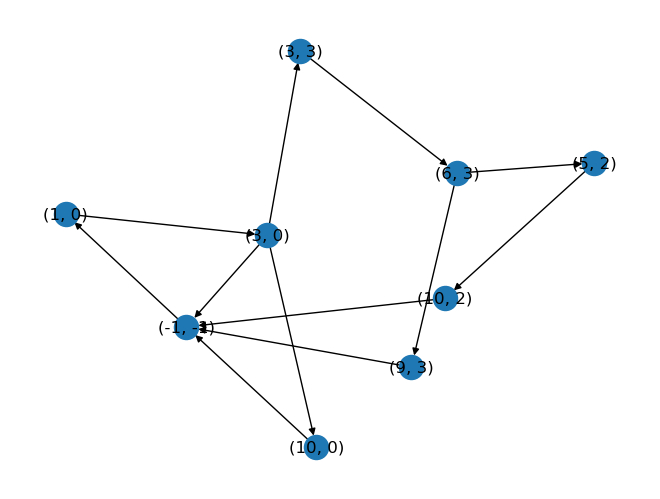

In [82]:
prob_graph = nx.from_pandas_edgelist(edgelist, edge_attr=['weight', 'state'], create_using=nx.DiGraph)
nx.draw(prob_graph, with_labels=True)

In [83]:
import networkx as nx
import pandas as pd
from typing import List, Tuple

def get_ribopaths(graph: nx.DiGraph, node_map: pd.DataFrame) -> List[List[Tuple]]:
    """
    Find all ribosome paths from load/ires nodes to the bulk node (-1,-1).

    Args:
        graph: networkx.DiGraph representing ribosome transitions.
        node_map: DataFrame containing node info (must have 'type' and 'node' columns).

    Returns:
        List of paths, each path is a list of edge tuples (source, target).
    """
    all_paths = []

    # source nodes: 'load' or 'ires'
    source_nodes = graph.successors((-1,-1))

    target_node = (-1, -1)  # bulk node
    for source in source_nodes:
        paths = nx.all_simple_edge_paths(graph, source=source, target=target_node)
        all_paths.extend(paths)

    return all_paths


paths = get_ribopaths(prob_graph, node_map=graph)
print(paths)


[[((1, 0), (3, 0)), ((3, 0), (3, 3)), ((3, 3), (6, 3)), ((6, 3), (5, 2)), ((5, 2), (10, 2)), ((10, 2), (-1, -1))], [((1, 0), (3, 0)), ((3, 0), (3, 3)), ((3, 3), (6, 3)), ((6, 3), (9, 3)), ((9, 3), (-1, -1))], [((1, 0), (3, 0)), ((3, 0), (10, 0)), ((10, 0), (-1, -1))], [((1, 0), (3, 0)), ((3, 0), (-1, -1))]]


In [84]:
import pandas as pd
import networkx as nx
from typing import List, Tuple

def calc_flux(graph: nx.DiGraph, edgelist: pd.DataFrame, edge_paths: List[List[Tuple]]) -> pd.DataFrame:
    """
    Calculate flux for each edge based on ribosome paths.

    Args:
        graph: nx.DiGraph with edge attribute 'weight'.
        edgelist: DataFrame with columns ['node', 'target', 'weight', 'state'].
        edge_paths: List of paths, each a list of edge tuples (source, target).

    Returns:
        DataFrame with columns ['node','target','weight','state','flux'].
    """

    out = edgelist.copy()
    out['edge_tuple'] = list(zip(out['source'], out['target']))

    # Initialize flux accumulator
    flux_accum = pd.Series(0, index=out.index)

    for path in edge_paths:
        # Calculate path flux (product of edge weights along path)
        path_flux = 1.0
        for edge in path:
            path_flux *= graph[edge[0]][edge[1]]['weight']

        # Map this path flux to the edges in the edgelist
        mask = out['edge_tuple'].isin(path)
        flux_accum[mask] += path_flux

    out['flux'] = flux_accum
    return out[['source', 'target', 'weight', 'state', 'flux']]


      source    target  weight  state  flux
0   (-1, -1)    (1, 0)    1.00   load  1.00
1     (3, 0)    (3, 3)    0.50   init  0.50
2     (6, 3)    (5, 2)    0.50  shift  0.25
3     (1, 0)    (3, 0)    1.00   scan  1.00
4     (3, 3)    (6, 3)    1.00  tran3  0.50
5     (5, 2)   (10, 2)    1.00  tran2  0.25
6     (3, 0)   (10, 0)    0.49   scan  0.49
7     (6, 3)    (9, 3)    0.50  tran3  0.25
11   (10, 0)  (-1, -1)    1.00   drop  0.49
12   (10, 2)  (-1, -1)    1.00   drop  0.25
13    (3, 0)  (-1, -1)    0.01   drop  0.01
14    (9, 3)  (-1, -1)    1.00   drop  0.25


/tmp/ipykernel_28358/1516173858.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.25 0.25 0.25 0.25 0.25 0.25]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  flux_accum[mask] += path_flux


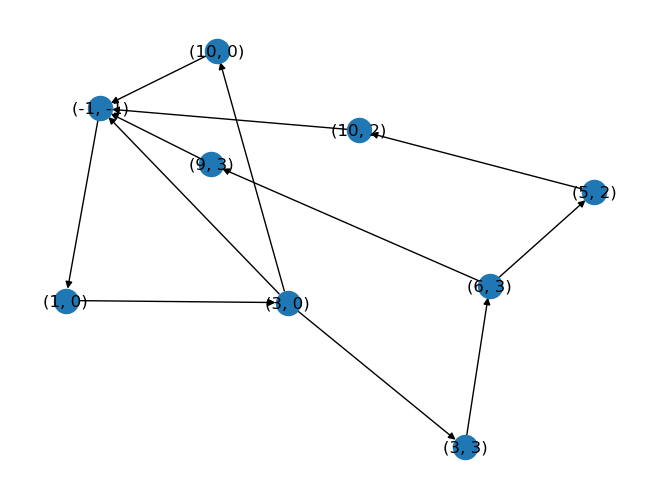

In [85]:
import networkx as nx
import pandas as pd
from typing import List, Tuple

def build_flux_graph(
    prob_graph: nx.DiGraph,
    edgelist: pd.DataFrame,
    ribopaths: List[List[Tuple]],
    csv_path: str = None
) -> Tuple[pd.DataFrame, nx.DiGraph]:
    """
    Calculate ribosome flux along edges and generate a weighted DiGraph.

    Args:
        prob_graph: Original probabilistic DiGraph.
        edgelist: DataFrame with edges ['node','target','weight','state'].
        ribopaths: List of paths (list of edge tuples) through the graph.
        csv_path: Optional path to save the fluxed edge table as CSV.

    Returns:
        flux_edges: DataFrame with additional 'flux' column.
        flux_graph: NetworkX DiGraph with edge attributes ['state','weight','flux'].
    """
    # Compute flux along all paths
    flux_edges = calc_flux(prob_graph, edgelist, ribopaths).copy()

    # Standardize column names
    flux_edges.columns = ['source', 'target', 'weight', 'state', 'flux']

    flux_edges.loc[flux_edges['state']=='load', 'flux'] = 1


    # Build DiGraph with edge attributes
    flux_graph = nx.from_pandas_edgelist(
        flux_edges,
        source='source',
        target='target',
        edge_attr=['state', 'weight', 'flux'],
        create_using=nx.DiGraph
    )

    # Optional: save to CSV
    if csv_path is not None:
        flux_edges.to_csv(csv_path, index=False, sep='\t')

    return flux_edges, flux_graph

flux_graph, nx_flux_graph = build_flux_graph(prob_graph, edgelist, paths, csv_path='graph.csv')
print(flux_graph)
nx.draw(nx_flux_graph, with_labels=True)